In [24]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.bp as bp
import pyeit.eit.greit as greit
import pyeit.eit.jac as jac
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from pyeit.eit.interp2d import sim2pts
from sciopy import norm_data
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Add,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv1D,
    Conv2D,
    ConvLSTM1D,
    Cropping1D,
    Cropping2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPooling1D,
    Normalization,
    Reshape,
    ZeroPadding1D,
)
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

In [2]:
from IPython.display import IFrame
IFrame("../images/LSTM_VAE_V3.pdf", width=600, height=400)

# VAE & LSTM V2 for n_el=16

### Build VAE

In [3]:
n_el = 16
r_obj = 0.3
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_30 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_30):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [4]:
n_el = 16
r_obj = 0.35
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_35 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_35):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [5]:
n_el = 16
r_obj = 0.4
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_40 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_40):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [6]:
V_30 = np.load(
    "../saves/" + load_path_30.split("/")[2] + "_v_data.npy", allow_pickle=True
)[::1]
V_35 = np.load(
    "../saves/" + load_path_35.split("/")[2] + "_v_data.npy", allow_pickle=True
)[::1]
V_40 = np.load(
    "../saves/" + load_path_40.split("/")[2] + "_v_data.npy", allow_pickle=True
)[::1]

In [7]:
print(V_30.shape)
print(V_35.shape)
print(V_40.shape)

(999, 192)
(999, 192)
(999, 192)


In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = keras.backend.random_normal(
        shape=(keras.backend.shape(z_mean)[0], latent_dim)
    )
    return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

In [9]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(192,))

x = layers.Dense(128, activation="relu")(encoder_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          24704       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                            

2023-10-25 13:25:23.497367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-10-25 13:25:23.499219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46672 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [10]:
# Definiere den Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(192, activation="relu")(x)
decoder_outputs = layers.Flatten()(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_4 (Dense)             (None, 16)                80        
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 192)               24768     
                                                                 
 flatten_1 (Flatten)         (None, 192)               0   

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(mse_loss)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [12]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [13]:
V_all = np.concatenate((V_30, V_35, V_40))
#V_all = V_30

<StemContainer object of 3 artists>

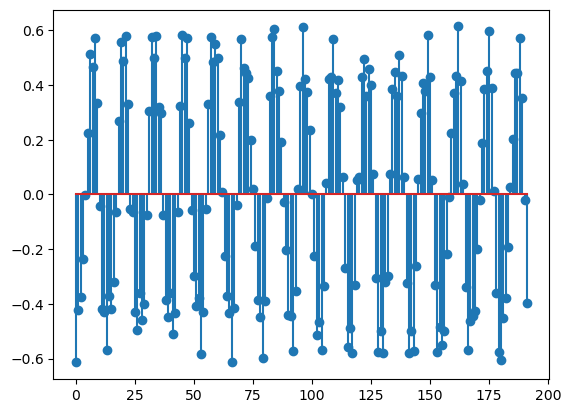

In [14]:
plt.stem(V_all[100, :])

In [15]:
V_vae_train, V_vae_test = train_test_split(
    V_all, test_size=0.05, shuffle=True, random_state=52
)

In [16]:
print(V_vae_train.shape, V_vae_test.shape)
print(np.min(V_all), np.max(V_all))

(2847, 192) (150, 192)
-0.6159002458182258 0.6159002458182258


In [17]:
history = vae.fit(V_vae_train, epochs=150, batch_size=64)
#history = vae.fit(V_all, epochs=50, batch_size=32)

Epoch 1/150


2023-10-25 13:25:26.703501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-25 13:25:26.738015: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x56137f5e1f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-25 13:25:26.738043: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-25 13:25:26.738054: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-25 13:25:26.745071: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-25 13:25:26.937855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-25 13:25:27.08172

45/45 [==============================] - 5s 7ms/step - loss: 0.1310 - reconstruction_loss: 0.1031 - kl_loss: 0.0040
Epoch 2/150
45/45 [==============================] - 0s 7ms/step - loss: 0.0862 - reconstruction_loss: 0.0850 - kl_loss: 3.8059e-05
Epoch 3/150
45/45 [==============================] - 0s 7ms/step - loss: 0.0830 - reconstruction_loss: 0.0828 - kl_loss: 9.0245e-06
Epoch 4/150
45/45 [==============================] - 0s 7ms/step - loss: 0.0822 - reconstruction_loss: 0.0823 - kl_loss: 5.9393e-06
Epoch 5/150
45/45 [==============================] - 0s 7ms/step - loss: 0.0822 - reconstruction_loss: 0.0822 - kl_loss: 4.3921e-06
Epoch 6/150
45/45 [==============================] - 0s 7ms/step - loss: 0.0822 - reconstruction_loss: 0.0822 - kl_loss: 3.5343e-06
Epoch 7/150
45/45 [==============================] - 0s 7ms/step - loss: 0.0823 - reconstruction_loss: 0.0822 - kl_loss: 2.8490e-06
Epoch 8/150
45/45 [==============================] - 0s 7ms/step - loss: 0.0822 - reconstruc

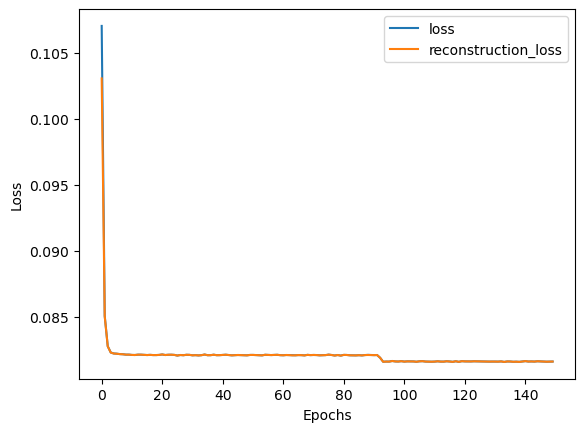

In [19]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
z_mean, z_log_var, latent_data = vae.encoder.predict(V_40[::5])

7/7 [==============================] - 0s 1ms/step


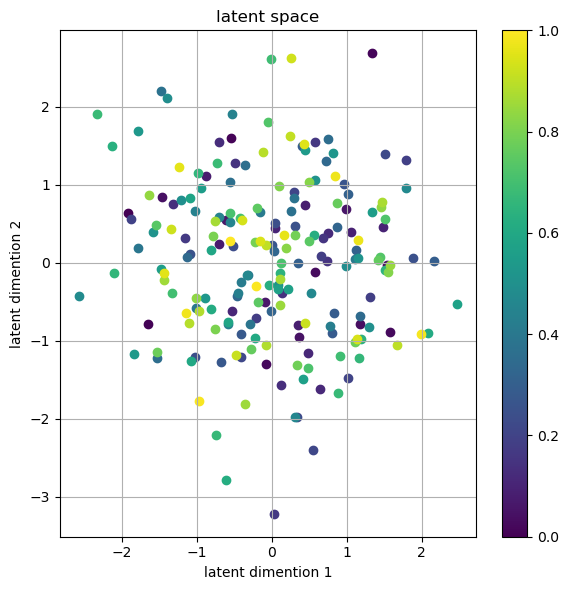

In [21]:
# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2)
latent_space_2d = tsne.fit_transform(latent_data)

plt.figure(figsize=(6, 6))

plt.title("latent space")
colors = plt.cm.viridis(np.linspace(0, 1, latent_data.shape[0]))

for i, ele in enumerate(latent_data):
    plt.scatter(ele[0], ele[1], color=colors[i])
plt.xlabel("latent dimention 1")
plt.ylabel("latent dimention 2")
plt.colorbar()
plt.grid()
plt.tight_layout()
plt.show()

### Build LSTM

In [22]:
V_z_mean_30, V_z_log_var_30, V_z_30 = vae.encoder.predict(V_30)
V_z_mean_35, V_z_log_var_35, V_z_35 = vae.encoder.predict(V_35)
V_z_mean_40, V_z_log_var_40, V_z_40 = vae.encoder.predict(V_40)

32/32 [==============================] - 0s 852us/step


In [25]:
scaler_V_z_30 = MinMaxScaler()
scaler_V_z_35 = MinMaxScaler()
scaler_V_z_40 = MinMaxScaler()

scaler_V_z_30.fit(V_z_30)
scaler_V_z_35.fit(V_z_35)
scaler_V_z_40.fit(V_z_40)

V_z_30 = scaler_V_z_30.transform(V_z_30)
V_z_35 = scaler_V_z_35.transform(V_z_35)
V_z_40 = scaler_V_z_40.transform(V_z_40)

In [26]:
# creates overlapping segments with a length of nseg
nseg = 6

X0_30 = [V_z_30[n : n + nseg, :] for n in range(V_z_30.shape[0] - nseg + 1)]
X0_30 = np.array(X0_30)

X0_35 = [V_z_35[n : n + nseg, :] for n in range(V_z_35.shape[0] - nseg + 1)]
X0_35 = np.array(X0_35)

X0_40 = [V_z_40[n : n + nseg, :] for n in range(V_z_40.shape[0] - nseg + 1)]
X0_40 = np.array(X0_40)

Y0_30 = np.array(V_z_30[nseg - 1 :])
Y0_35 = np.array(V_z_35[nseg - 1 :])
Y0_40 = np.array(V_z_40[nseg - 1 :])

In [27]:
print(X0_30.shape, Y0_30.shape)
print(X0_35.shape, Y0_35.shape)
print(X0_40.shape, Y0_40.shape)

(994, 6, 4) (994, 4)
(994, 6, 4) (994, 4)
(994, 6, 4) (994, 4)


In [28]:
X0_30_35_40 = np.concatenate((X0_30, X0_35, X0_40))
Y0_30_35_40 = np.concatenate((Y0_30, Y0_35, Y0_40))
print(X0_30_35_40.shape, Y0_30_35_40.shape)

(2982, 6, 4) (2982, 4)


In [29]:
X_lstm_train, X_lstm_test, Y_lstm_train, Y_lstm_test = train_test_split(
    X0_30_35_40, Y0_30_35_40, test_size=0.05, shuffle=True, random_state=52
)

In [30]:
print(X_lstm_train.shape, Y_lstm_train.shape)
print(X_lstm_test.shape, Y_lstm_test.shape)

print(np.min(X_lstm_train), np.max(X_lstm_train))
print(np.median(X_lstm_train))

(2832, 6, 4) (2832, 4)
(150, 6, 4) (150, 4)
0.0 1.0
0.49897212


In [31]:
def lstm_split(input_shape, nseg, v_shape):
    def Slice(s):
        # function for slicing x
        def func(x):
            return x[:, s, :]

        return func

    # define shared layers
    dense = Dense(v_shape, activation="relu")
    inputs = Input(shape=input_shape)
    con_list = []
    for s in range(nseg):
        # slicing x
        x = Lambda(Slice(s))(inputs)
        # shared layers
        x = dense(x)
        con_list.append(x)

    # concat and reshape for LSTM
    x = Concatenate(axis=1)(con_list)
    x = Reshape((nseg, int(x.shape[1] / nseg)))(x)

    x = LSTM(v_shape)(x)
    x = Activation("softmax")(x)

    return Model(inputs, x)

In [32]:
lstm = lstm_split(
    input_shape=(nseg, latent_dim), nseg=nseg, v_shape=Y0_30_35_40.shape[1]
)
lstm.compile(optimizer="adam", loss="binary_crossentropy")
print(lstm.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 4)]       0           []                               
                                                                                                  
 lambda (Lambda)                (None, 4)            0           ['input_2[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 4)            0           ['input_2[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 4)            0           ['input_2[0][0]']                
                                                                                              

2023-10-25 13:36:15.747509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 13:36:15.748751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 13:36:15.749658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [33]:
epochs = 100
batch_size = 8

history = lstm.fit(
    X_lstm_train,
    Y_lstm_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_lstm_test, Y_lstm_test),
)

Epoch 1/100


2023-10-25 13:36:16.060700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 13:36:16.062132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 13:36:16.063172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

348/354 [============================>.] - ETA: 0s - loss: 0.6920

2023-10-25 13:36:19.850627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 13:36:19.852219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 13:36:19.853304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

354/354 [==============================] - 4s 7ms/step - loss: 0.6920 - val_loss: 0.6911
Epoch 2/100
354/354 [==============================] - 2s 5ms/step - loss: 0.6897 - val_loss: 0.6890
Epoch 3/100
354/354 [==============================] - 2s 5ms/step - loss: 0.6867 - val_loss: 0.6857
Epoch 4/100
354/354 [==============================] - 2s 5ms/step - loss: 0.6833 - val_loss: 0.6823
Epoch 5/100
354/354 [==============================] - 2s 5ms/step - loss: 0.6804 - val_loss: 0.6799
Epoch 6/100
354/354 [==============================] - 2s 5ms/step - loss: 0.6779 - val_loss: 0.6778
Epoch 7/100
354/354 [==============================] - 2s 5ms/step - loss: 0.6758 - val_loss: 0.6758
Epoch 8/100
354/354 [==============================] - 2s 5ms/step - loss: 0.6743 - val_loss: 0.6748
Epoch 9/100
354/354 [==============================] - 2s 5ms/step - loss: 0.6731 - val_loss: 0.6737
Epoch 10/100
354/354 [==============================] - 2s 5ms/step - loss: 0.6722 - val_loss: 0.6736
E

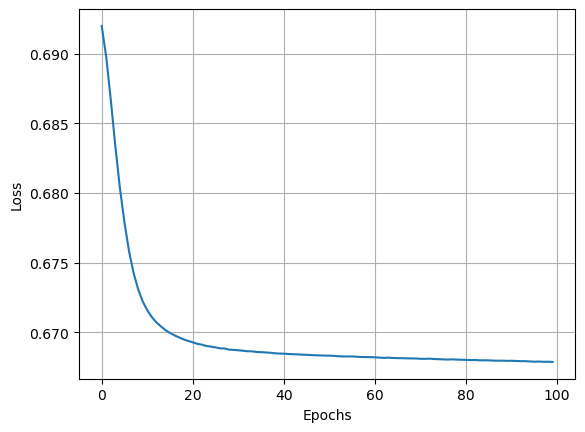

In [35]:
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [36]:
# 1. Vae -> komprimieren der nsegs
# 2. lstm vorhersage

In [37]:
print(X_lstm_test.shape, Y_lstm_test.shape)

(150, 6, 4) (150, 4)


In [38]:
pred = lstm.predict(X_lstm_test)

5/5 [==============================] - 0s 3ms/step


2023-10-25 13:50:40.523841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 13:50:40.525420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 13:50:40.526466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [46]:
print(np.min(pred), np.max(pred))

0.08364128 0.53969795


In [48]:
pred[:10, :]

array([[0.2605515 , 0.11665384, 0.41450116, 0.20829342],
       [0.23822479, 0.21181425, 0.38134688, 0.16861403],
       [0.53969795, 0.13380113, 0.156181  , 0.1703199 ],
       [0.20147453, 0.4974184 , 0.1736638 , 0.12744331],
       [0.35672218, 0.36690778, 0.15316573, 0.12320436],
       [0.418584  , 0.19023915, 0.16446017, 0.22671673],
       [0.16490652, 0.1511956 , 0.18194988, 0.501948  ],
       [0.2980979 , 0.10781483, 0.23442483, 0.35966247],
       [0.12892966, 0.2673646 , 0.30734262, 0.2963631 ],
       [0.2835973 , 0.08830997, 0.3277329 , 0.30035982]], dtype=float32)

In [47]:
Y_lstm_test[:10, :]

array([[0.5613042 , 0.38819155, 0.7147909 , 0.51056236],
       [0.5624202 , 0.53115565, 0.62649417, 0.464075  ],
       [0.7175732 , 0.15813604, 0.33417314, 0.34232813],
       [0.41965017, 0.67829144, 0.41213134, 0.20872739],
       [0.60504425, 0.5916996 , 0.38899198, 0.22219327],
       [0.4948507 , 0.33252603, 0.37557745, 0.40572497],
       [0.2855835 , 0.29082155, 0.43736342, 0.73428196],
       [0.4782172 , 0.21870042, 0.51732796, 0.5659602 ],
       [0.40764198, 0.56408465, 0.5891058 , 0.57915795],
       [0.8250408 , 0.4334951 , 0.7465727 , 0.72105426]], dtype=float32)

In [55]:
V_dec_40 = np.array(vae.decoder(pred_40))

<StemContainer object of 3 artists>

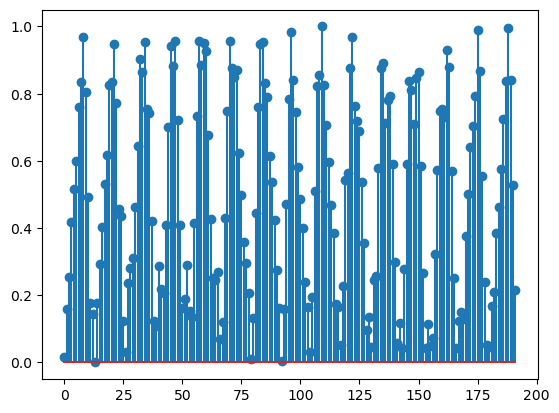

In [56]:
plt.stem(norm_data(V_40[14, :]))

### Inverse transform from VAE beginning

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# scalar.inverse_transform(X)

<StemContainer object of 3 artists>

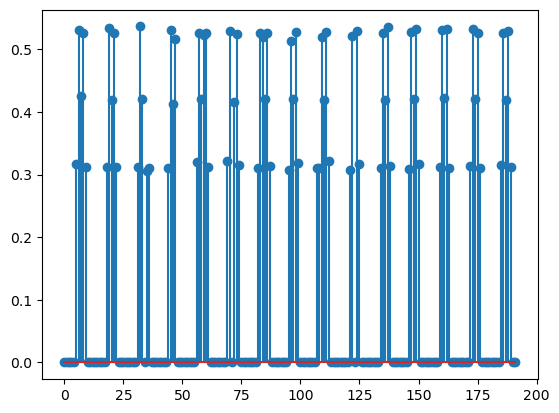

In [57]:
plt.stem(V_dec_40[14, :])

In [40]:
tmp_1 = np.load(load_path_40 + "sample_000000.npz", allow_pickle=True)
tmp_2 = np.load(load_path_40 + "sample_000015.npz", allow_pickle=True)

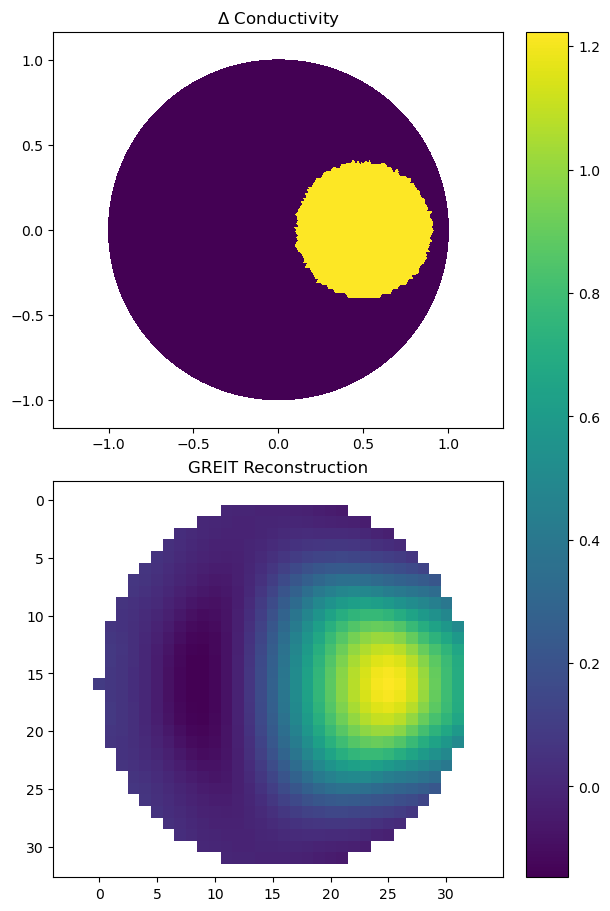

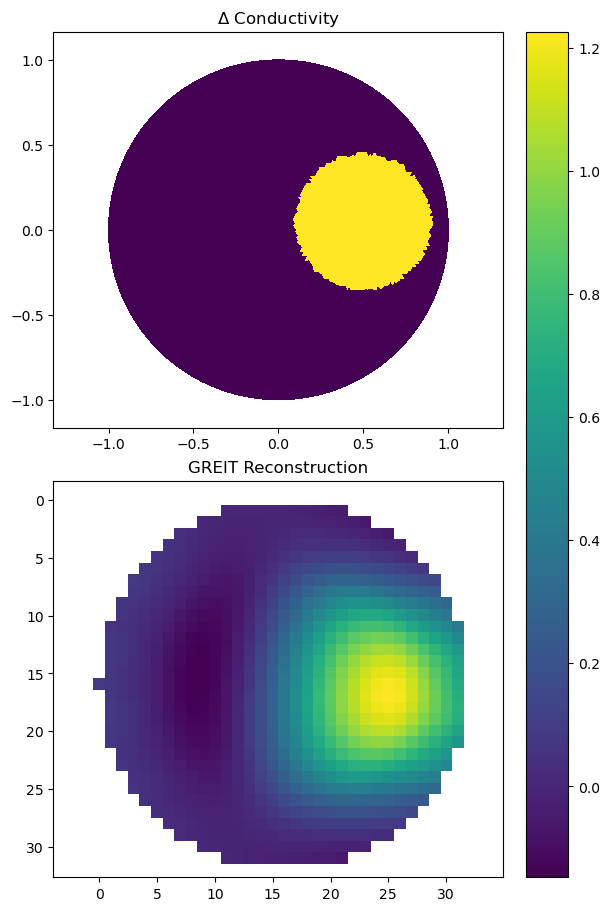

In [41]:
GREIT_sample(tmp_1,rec_only=False)
GREIT_sample(tmp_2,rec_only=False)

In [42]:
tmp_s = {
    "anomaly": tmp_1["anomaly"],
    "perm_array": tmp_1["perm_array"],
    "n_el": tmp_1["n_el"],
    "h0": tmp_1["h0"],
    "v_empty": tmp_1["v_obj"],
    "v_obj":  tmp_2["v_obj"],
    "dist_exc": tmp_1["dist_exc"],
    "step_meas": tmp_1["step_meas"],
}

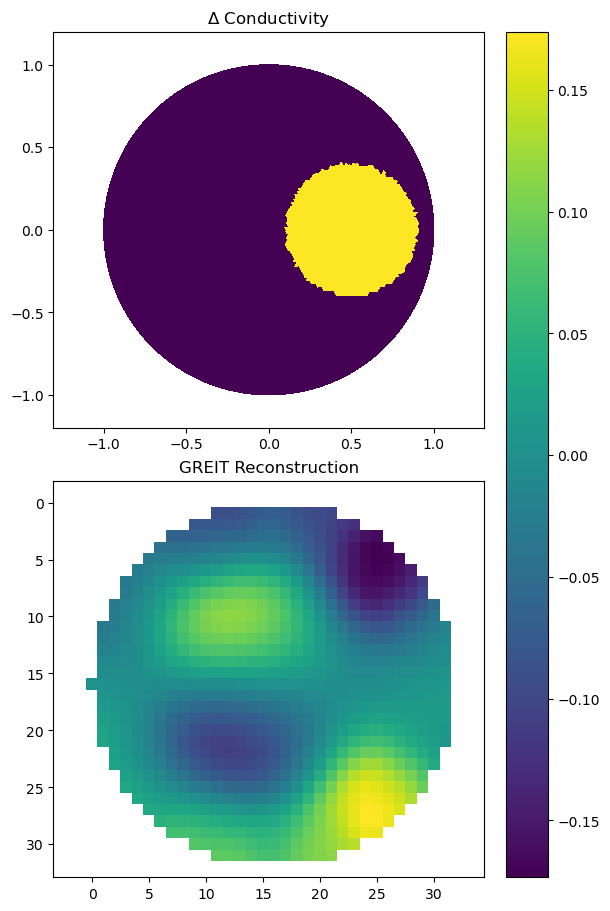

In [43]:
GREIT_sample(tmp_s, rec_only=False)

In [48]:
tmp_1["perm_array"].shape

(11433,)